In [30]:
import numpy as np
from numpy import asarray
from numpy import arange
from numpy.random import rand
from numpy.random import seed
import matplotlib.pyplot as plt
import seaborn as sns
from func_autograd import *
from sklearn.model_selection import train_test_split
import pandas as pd

def MSE(y_data, y_model):
	n = np.size(y_model)
	y_data = y_data.reshape(-1,1)
	y_model = y_model.reshape(-1,1)
	return np.sum((y_data - y_model)**2)/n


def generate_data(noise=True, step_size=0.05 , FrankesFunction=True):
    # Arrange x and y
    x = np.arange(0, 1, step_size)
    y = np.arange(0, 1, step_size)
    # Create meshgrid of x and y
    X, Y = np.meshgrid(x, y)
    
    if FrankesFunction:
        # Calculate the values for Franke function
        z = FrankeFunction(X, Y, noise=noise).flatten()
    else:
        z = TestFunction(X, Y, noise=noise).flatten()

    # Flatten x and y for plotting
    x = X.flatten()
    y = Y.flatten()
    
    return x, y, z

def TestFunction(x, y, noise=False):
    if noise: 
        random_noise = np.random.normal(0, 0.1 , x.shape)
    else: 
        random_noise = 0

    return  x**2 + y**2 + 2*x*y + random_noise

def FrankeFunction(x, y, noise=False):
    if noise: 
        random_noise = np.random.normal(0, 0.1 , x.shape)
    else: 
        random_noise = 0
    
    term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
    term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
    term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2))
    term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)
    return term1 + term2 + term3 + term4 + random_noise

x, y, z = generate_data()
X = np.column_stack((x,y))
X_train, X_test, z_train, z_test = train_test_split(X, z)


# data
MSE_val = np.zeros((9, 2))
index = ["gd", "gd_mom", "sgd", "gd_adagrad", "gd_mom_adagrad", "sgd_adagrad", "sgd_mom_adagrad", "sgd_mom_rmsprop", "sgd_mom_adam"]
gamma = np.linspace(0.001, 0.1, 20)
delta = np.linspace(0.05, 0.5, 20)

# plain gradient descent with fixed learning rate using analytic expression of gradient
train_score = np.zeros(len(gamma))
test_score = np.zeros(len(gamma))
for i in range(len(gamma)):
    model = GradientDescend(momentum=False, learning_rate=gamma[i])
    scores = model.fit(X_train, z_train, X_test, z_test)

    pred_train = model.predict(X_train)
    train_score[i] = MSE(pred_train, z_train)
    pred_test = model.predict(X_test)
    test_score[i] = MSE(pred_test, z_test)

i_min, min = np.argmin(train_score), np.min(train_score)
MSE_val[0, 0] = min
MSE_val[0, 1] = test_score[i_min]
print("gd: learning rate and minimal train MSE")
print(gamma[i_min], min)

# adding momentum
train_score = np.zeros((len(gamma), len(delta)))
test_score = np.zeros((len(gamma), len(delta)))
for j in range(len(delta)):
    for i in range(len(gamma)):
        model = GradientDescend(learning_rate=gamma[i], delta_momentum=delta[j])
        scores = model.fit(X_train, z_train, X_test, z_test)

        pred_train = model.predict(X_train)
        train_score[i, j] = MSE(pred_train, z_train)
        pred_test = model.predict(X_test)
        test_score[i, j] = MSE(pred_test, z_test)

i_min, min = np.argmin(train_score), np.min(train_score)
i_min = np.ravel(i_min, train_score)
MSE_val[1, 0] = min
MSE_val[1, 1] = test_score[i_min]
print("gd with momentum: learning rate, momentum and minimal train MSE")
print(gamma[i_min], min)
# minibatch sgd, learning schedule
# check method
model = GradientDescend(optimizer="sgd", method="gd")
scores = model.fit(X_train, z_train, X_test, z_test)

pred_train = model.predict(X_train)
MSE_val[2, 0] = MSE(pred_train, z_train)
pred_test = model.predict(X_test)
MSE_val[2, 1] = MSE(pred_test, z_test)

# adagrad 
# gd without momentum
model = GradientDescend(momentum=False, method="adagrad")
scores = model.fit(X_train, z_train, X_test, z_test)

pred_train = model.predict(X_train)
MSE_val[3, 0] = MSE(pred_train, z_train)
pred_test = model.predict(X_test)
MSE_val[3, 1] = MSE(pred_test, z_test)

# gd with momentum
model = GradientDescend(method="adagrad")
scores = model.fit(X_train, z_train, X_test, z_test)

pred_train = model.predict(X_train)
MSE_val[4, 0] = MSE(pred_train, z_train)
pred_test = model.predict(X_test)
MSE_val[4, 1] = MSE(pred_test, z_test)

# sgd without momentum
model = GradientDescend(optimizer="sgd", momentum=False, method="adagrad")
scores = model.fit(X_train, z_train, X_test, z_test)

pred_train = model.predict(X_train)
MSE_val[5, 0] = MSE(pred_train, z_train)
pred_test = model.predict(X_test)
MSE_val[5, 1] = MSE(pred_test, z_test)

# sgd with momentum
model = GradientDescend(optimizer="sgd", method="adagrad")
scores = model.fit(X_train, z_train, X_test, z_test)

pred_train = model.predict(X_train)
MSE_val[6, 0] = MSE(pred_train, z_train)
pred_test = model.predict(X_test)
MSE_val[6, 1] = MSE(pred_test, z_test)

# rms prop and adam
# We chose to only evaluate sgd with momentum for this
model = GradientDescend(optimizer="sgd", method="rmsprop")
scores = model.fit(X_train, z_train, X_test, z_test)

pred_train = model.predict(X_train)
MSE_val[7, 0] = MSE(pred_train, z_train)
pred_test = model.predict(X_test)
MSE_val[7, 1] = MSE(pred_test, z_test)

model = GradientDescend(optimizer="sgd", method="adam")
scores = model.fit(X_train, z_train, X_test, z_test)

pred_train = model.predict(X_train)
MSE_val[8, 0] = MSE(pred_train, z_train)
pred_test = model.predict(X_test)
MSE_val[8, 1] = MSE(pred_test, z_test)



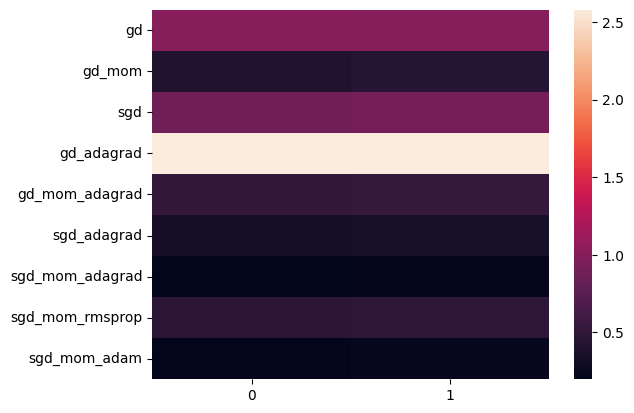

In [10]:
df = pd.DataFrame(MSE_val, index=index)
sns.heatmap(df)

